In [1]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from synth_dim_model import *

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
def construct_anisotropic_hamiltonian(N, M, V, mu, J, anisotropy_factor=1.0, chemical_potential_loc=0):
    dim = M**N
    H = np.zeros((dim, dim), dtype=np.complex128)
    
    M_powers = np.array([M**i for i in range(N)])

    def index_to_state(index):
        return np.array([(index // M_powers[i]) % M for i in range(N-1, -1, -1)])
    
    def state_to_index(state):
        return np.dot(state, M_powers[::-1])

    # Chemical potential term
    for alpha in range(dim):
        state = index_to_state(alpha)
        for j in range(N):
            if state[j] == chemical_potential_loc:
                H[alpha, alpha] -= mu

    # Tunneling term (level lowering)
    for alpha in range(dim):
        state = index_to_state(alpha)
        for j in range(N):
            n = state[j]
            if n > 0:
                new_state = state.copy()
                new_state[j] = n - 1
                beta = state_to_index(new_state)
                H[alpha, beta] -= J
                H[beta, alpha] -= J

    # Interaction term (between neighbors)
    for alpha in range(dim):
        state = index_to_state(alpha)
        for i in range(N - 1):
            a, b = state[i], state[i+1]
            if a == 1 and b == 0:
                new_state = state.copy()
                new_state[i], new_state[i+1] = 0, 1
                beta = state_to_index(new_state)
                H[alpha, beta] += anisotropy_factor * V
                H[beta, alpha] += anisotropy_factor * V
            elif a == 2 and b == 1:
                new_state = state.copy()
                new_state[i], new_state[i+1] = 1, 2
                beta = state_to_index(new_state)
                H[alpha, beta] += V
                H[beta, alpha] += V

    return H


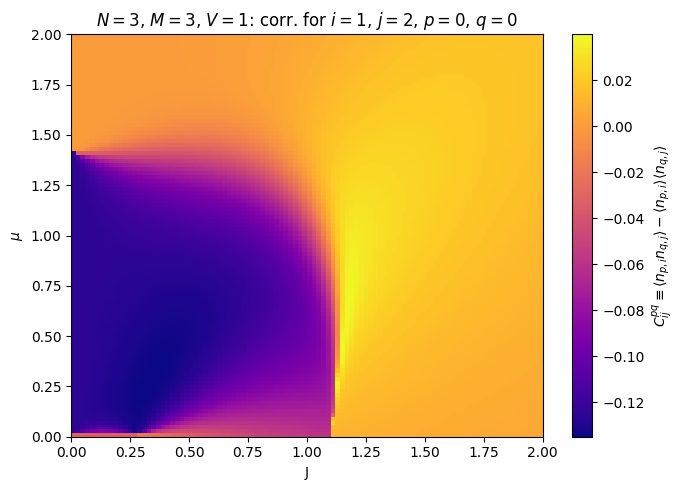

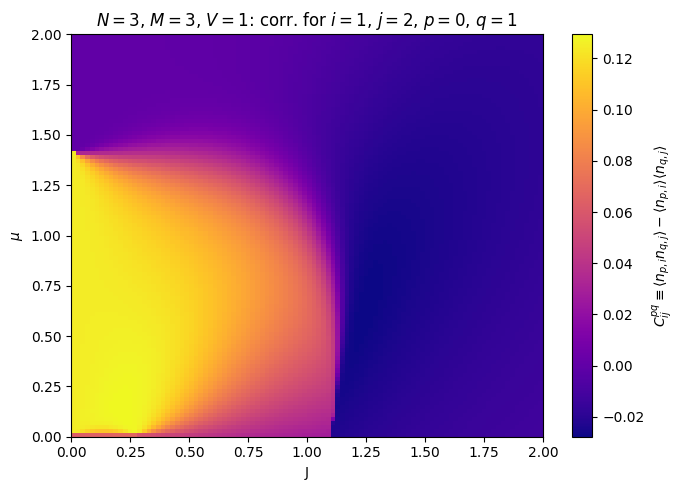

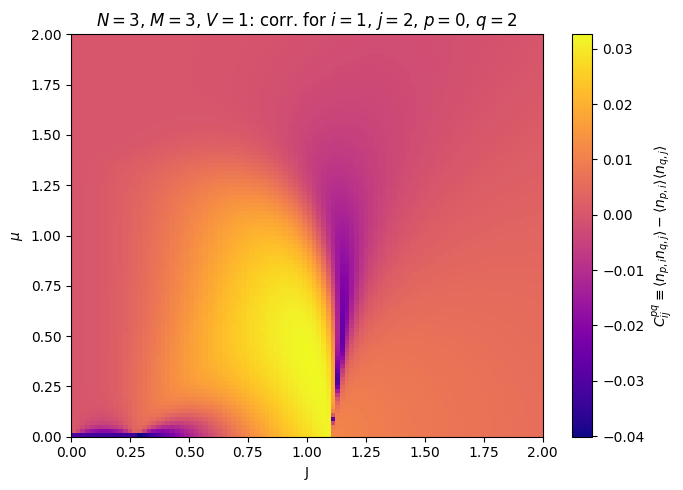

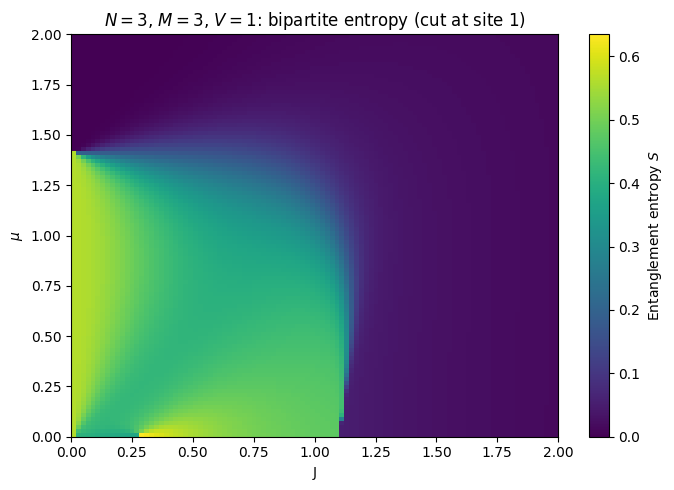

In [3]:
# positive V, no anisotropy 

N = 3
M = 3
V = 1
anisotropy_factor = 1

states, _ = enumerate_states(N, M)

Js = np.linspace(0, 2, 100)
mus = np.linspace(0, 2, 100)

site_1 = N // 2
site_2 = site_1 + 1

same_synth_level_corr_func_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)
diff_by_1_synth_level_corr_func_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)
diff_by_2_synth_level_corr_func_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)
entropy_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)

for i, mu in enumerate(mus):
    for j, J in enumerate(Js):
        hamiltonian = construct_anisotropic_hamiltonian(N = N, M = M, V = V, mu = mu, J = J, anisotropy_factor=anisotropy_factor) # 0.9 anisotropy factor
        eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)

        P, degenerate_states = construct_ground_state_projector(eigenvalues, eigenvectors)
        d = len(degenerate_states)

        # Entanglement entropy (bipartition in the middle)
        entropies = [compute_entanglement_entropy(N, M, psi, cut_site=N // 2) for psi in degenerate_states]
        entropy_grid[i, j] = np.mean(entropies)
        
        # Correlation function
        op1 = single_site_number_operator(N, M, site_index=site_1, synth_level = 0, states=states)
        for synth_level in range(M):
            op2 = single_site_number_operator(N, M, site_index=site_2, synth_level = synth_level, states=states)
            
            if synth_level == 0:
                O1O2_exp = np.trace(P @ op1 @ op2) / d
                O1_exp = np.trace(P @ op1) / d
                O2_exp = np.trace(P @ op2) / d
                same_synth_level_corr_func_grid[i, j] = np.real(O1O2_exp - O1_exp * O2_exp)
                
            elif synth_level == 1:
                O1O2_exp = np.trace(P @ op1 @ op2) / d
                O1_exp = np.trace(P @ op1) / d
                O2_exp = np.trace(P @ op2) / d
                diff_by_1_synth_level_corr_func_grid[i, j] = np.real(O1O2_exp - O1_exp * O2_exp)
            
            elif synth_level == 2:
                O1O2_exp = np.trace(P @ op1 @ op2) / d
                O1_exp = np.trace(P @ op1) / d
                O2_exp = np.trace(P @ op2) / d
                diff_by_2_synth_level_corr_func_grid[i, j] = np.real(O1O2_exp - O1_exp * O2_exp)
                
fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    same_synth_level_corr_func_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='plasma'
)
fig.colorbar(c, ax=ax, label=r'$C_{ij}^{pq} \equiv \langle n_{p,i} n_{q,j} \rangle - \langle n_{p,i} \rangle \langle n_{q,j} \rangle$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: corr. for $i={site_1}$, $j={site_2}$, $p={0}$, $q={0}$")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    diff_by_1_synth_level_corr_func_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='plasma'
)
fig.colorbar(c, ax=ax, label=r'$C_{ij}^{pq} \equiv \langle n_{p,i} n_{q,j} \rangle - \langle n_{p,i} \rangle \langle n_{q,j} \rangle$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: corr. for $i={site_1}$, $j={site_2}$, $p={0}$, $q={1}$")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    diff_by_2_synth_level_corr_func_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='plasma'
)
fig.colorbar(c, ax=ax, label=r'$C_{ij}^{pq} \equiv \langle n_{p,i} n_{q,j} \rangle - \langle n_{p,i} \rangle \langle n_{q,j} \rangle$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: corr. for $i={site_1}$, $j={site_2}$, $p={0}$, $q={2}$")
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    entropy_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='viridis'
)
fig.colorbar(c, ax=ax, label=r'Entanglement entropy $S$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: bipartite entropy (cut at site {N//2})")
plt.tight_layout()
plt.show()


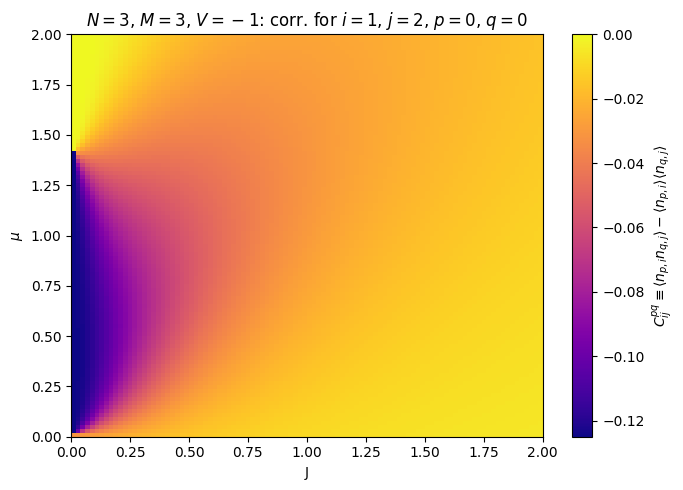

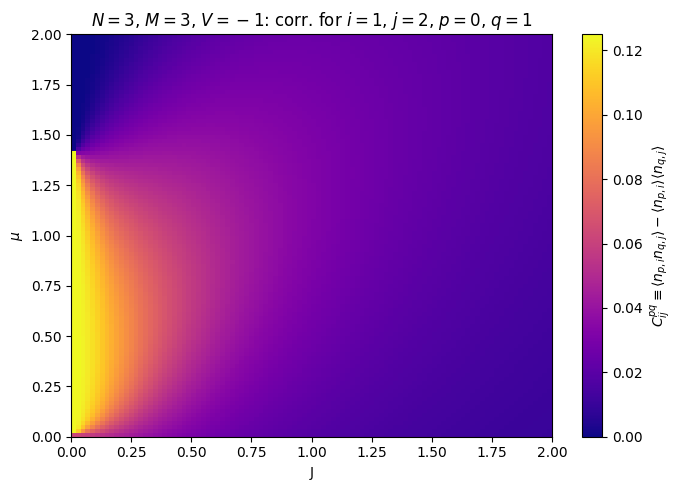

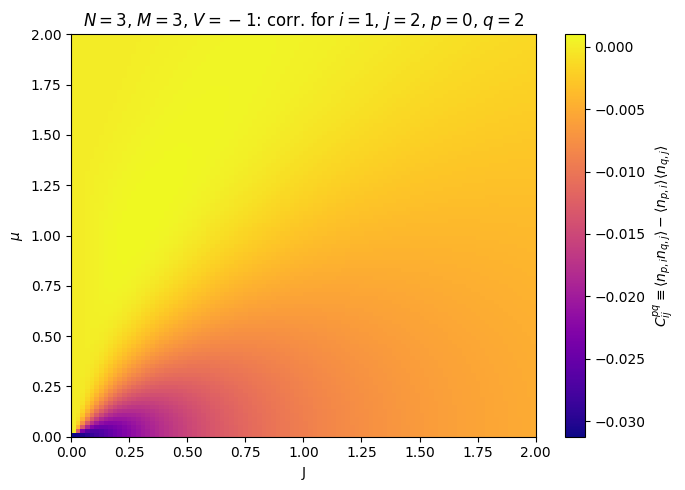

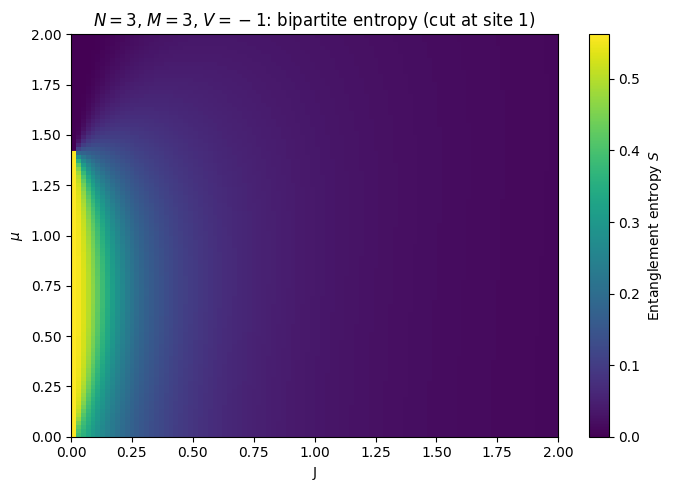

In [4]:
# negative V, no anisotropy 

N = 3
M = 3
V = -1
anisotropy_factor = 1

states, _ = enumerate_states(N, M)

Js = np.linspace(0, 2, 100)
mus = np.linspace(0, 2, 100)

site_1 = N // 2
site_2 = site_1 + 1

same_synth_level_corr_func_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)
diff_by_1_synth_level_corr_func_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)
diff_by_2_synth_level_corr_func_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)
entropy_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)

for i, mu in enumerate(mus):
    for j, J in enumerate(Js):
        hamiltonian = construct_anisotropic_hamiltonian(N = N, M = M, V = V, mu = mu, J = J, anisotropy_factor=anisotropy_factor) # 0.9 anisotropy factor
        eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)

        P, degenerate_states = construct_ground_state_projector(eigenvalues, eigenvectors)
        d = len(degenerate_states)

        # Entanglement entropy (bipartition in the middle)
        entropies = [compute_entanglement_entropy(N, M, psi, cut_site=N // 2) for psi in degenerate_states]
        entropy_grid[i, j] = np.mean(entropies)
        
        # Correlation function
        op1 = single_site_number_operator(N, M, site_index=site_1, synth_level = 0, states=states)
        for synth_level in range(M):
            op2 = single_site_number_operator(N, M, site_index=site_2, synth_level = synth_level, states=states)
            
            if synth_level == 0:
                O1O2_exp = np.trace(P @ op1 @ op2) / d
                O1_exp = np.trace(P @ op1) / d
                O2_exp = np.trace(P @ op2) / d
                same_synth_level_corr_func_grid[i, j] = np.real(O1O2_exp - O1_exp * O2_exp)
                
            elif synth_level == 1:
                O1O2_exp = np.trace(P @ op1 @ op2) / d
                O1_exp = np.trace(P @ op1) / d
                O2_exp = np.trace(P @ op2) / d
                diff_by_1_synth_level_corr_func_grid[i, j] = np.real(O1O2_exp - O1_exp * O2_exp)
            
            elif synth_level == 2:
                O1O2_exp = np.trace(P @ op1 @ op2) / d
                O1_exp = np.trace(P @ op1) / d
                O2_exp = np.trace(P @ op2) / d
                diff_by_2_synth_level_corr_func_grid[i, j] = np.real(O1O2_exp - O1_exp * O2_exp)
                
fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    same_synth_level_corr_func_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='plasma'
)
fig.colorbar(c, ax=ax, label=r'$C_{ij}^{pq} \equiv \langle n_{p,i} n_{q,j} \rangle - \langle n_{p,i} \rangle \langle n_{q,j} \rangle$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: corr. for $i={site_1}$, $j={site_2}$, $p={0}$, $q={0}$")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    diff_by_1_synth_level_corr_func_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='plasma'
)
fig.colorbar(c, ax=ax, label=r'$C_{ij}^{pq} \equiv \langle n_{p,i} n_{q,j} \rangle - \langle n_{p,i} \rangle \langle n_{q,j} \rangle$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: corr. for $i={site_1}$, $j={site_2}$, $p={0}$, $q={1}$")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    diff_by_2_synth_level_corr_func_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='plasma'
)
fig.colorbar(c, ax=ax, label=r'$C_{ij}^{pq} \equiv \langle n_{p,i} n_{q,j} \rangle - \langle n_{p,i} \rangle \langle n_{q,j} \rangle$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: corr. for $i={site_1}$, $j={site_2}$, $p={0}$, $q={2}$")
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    entropy_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='viridis'
)
fig.colorbar(c, ax=ax, label=r'Entanglement entropy $S$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: bipartite entropy (cut at site {N//2})")
plt.tight_layout()
plt.show()


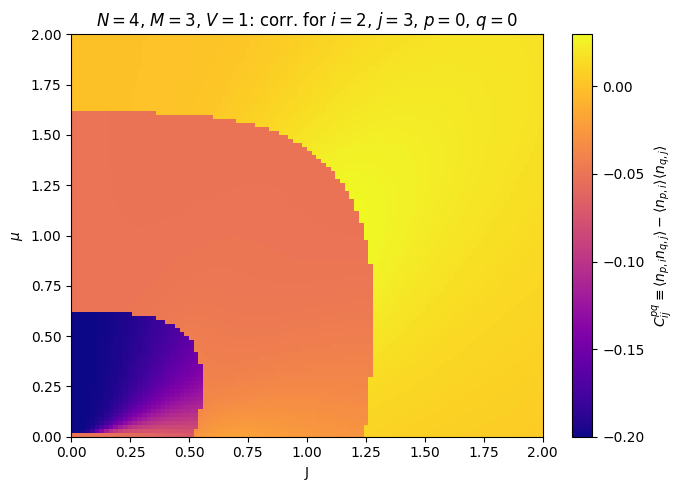

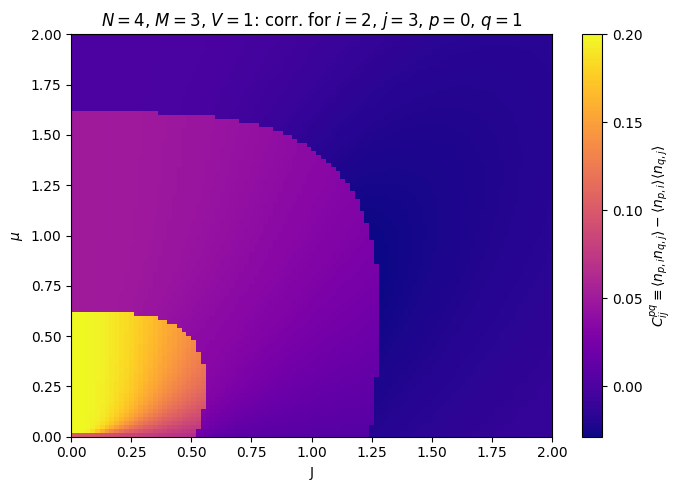

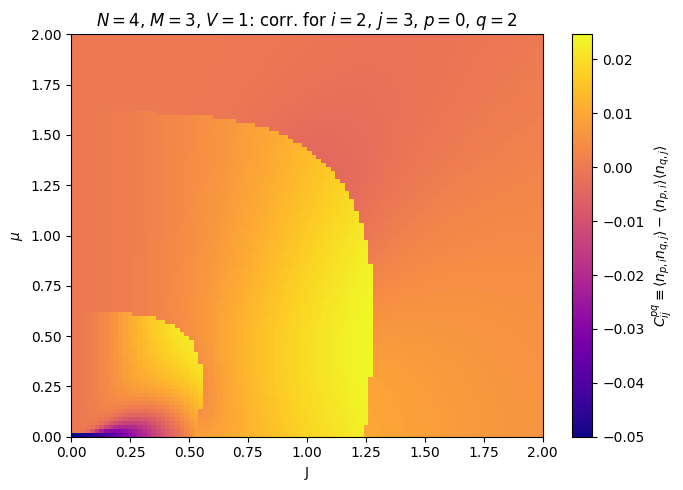

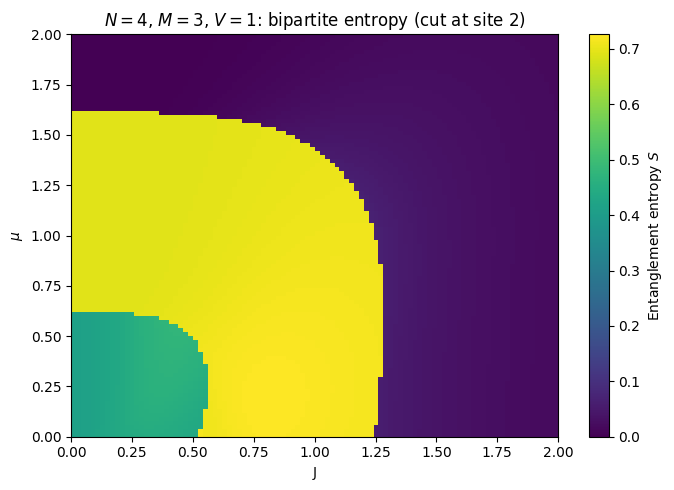

In [5]:
# positive V, no anisotropy at N = 4

N = 4
M = 3
V = 1
anisotropy_factor = 1

states, _ = enumerate_states(N, M)

Js = np.linspace(0, 2, 100)
mus = np.linspace(0, 2, 100)

site_1 = N // 2
site_2 = site_1 + 1

same_synth_level_corr_func_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)
diff_by_1_synth_level_corr_func_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)
diff_by_2_synth_level_corr_func_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)
entropy_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)

for i, mu in enumerate(mus):
    for j, J in enumerate(Js):
        hamiltonian = construct_anisotropic_hamiltonian(N = N, M = M, V = V, mu = mu, J = J, anisotropy_factor=anisotropy_factor) # 0.9 anisotropy factor
        eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)

        P, degenerate_states = construct_ground_state_projector(eigenvalues, eigenvectors)
        d = len(degenerate_states)

        # Entanglement entropy (bipartition in the middle)
        entropies = [compute_entanglement_entropy(N, M, psi, cut_site=N // 2) for psi in degenerate_states]
        entropy_grid[i, j] = np.mean(entropies)
        
        # Correlation function
        op1 = single_site_number_operator(N, M, site_index=site_1, synth_level = 0, states=states)
        for synth_level in range(M):
            op2 = single_site_number_operator(N, M, site_index=site_2, synth_level = synth_level, states=states)
            
            if synth_level == 0:
                O1O2_exp = np.trace(P @ op1 @ op2) / d
                O1_exp = np.trace(P @ op1) / d
                O2_exp = np.trace(P @ op2) / d
                same_synth_level_corr_func_grid[i, j] = np.real(O1O2_exp - O1_exp * O2_exp)
                
            elif synth_level == 1:
                O1O2_exp = np.trace(P @ op1 @ op2) / d
                O1_exp = np.trace(P @ op1) / d
                O2_exp = np.trace(P @ op2) / d
                diff_by_1_synth_level_corr_func_grid[i, j] = np.real(O1O2_exp - O1_exp * O2_exp)
            
            elif synth_level == 2:
                O1O2_exp = np.trace(P @ op1 @ op2) / d
                O1_exp = np.trace(P @ op1) / d
                O2_exp = np.trace(P @ op2) / d
                diff_by_2_synth_level_corr_func_grid[i, j] = np.real(O1O2_exp - O1_exp * O2_exp)
                
fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    same_synth_level_corr_func_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='plasma'
)
fig.colorbar(c, ax=ax, label=r'$C_{ij}^{pq} \equiv \langle n_{p,i} n_{q,j} \rangle - \langle n_{p,i} \rangle \langle n_{q,j} \rangle$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: corr. for $i={site_1}$, $j={site_2}$, $p={0}$, $q={0}$")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    diff_by_1_synth_level_corr_func_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='plasma'
)
fig.colorbar(c, ax=ax, label=r'$C_{ij}^{pq} \equiv \langle n_{p,i} n_{q,j} \rangle - \langle n_{p,i} \rangle \langle n_{q,j} \rangle$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: corr. for $i={site_1}$, $j={site_2}$, $p={0}$, $q={1}$")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    diff_by_2_synth_level_corr_func_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='plasma'
)
fig.colorbar(c, ax=ax, label=r'$C_{ij}^{pq} \equiv \langle n_{p,i} n_{q,j} \rangle - \langle n_{p,i} \rangle \langle n_{q,j} \rangle$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: corr. for $i={site_1}$, $j={site_2}$, $p={0}$, $q={2}$")
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    entropy_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='viridis'
)
fig.colorbar(c, ax=ax, label=r'Entanglement entropy $S$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: bipartite entropy (cut at site {N//2})")
plt.tight_layout()
plt.show()


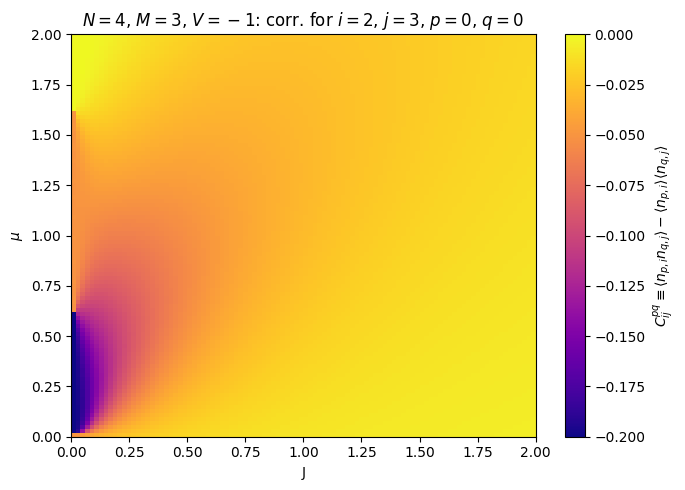

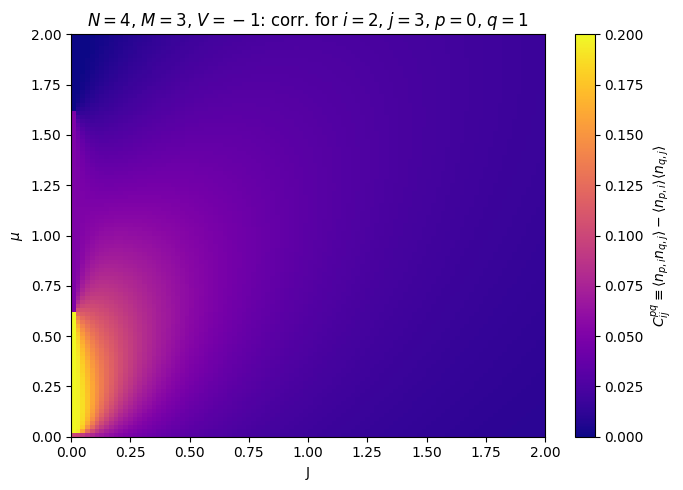

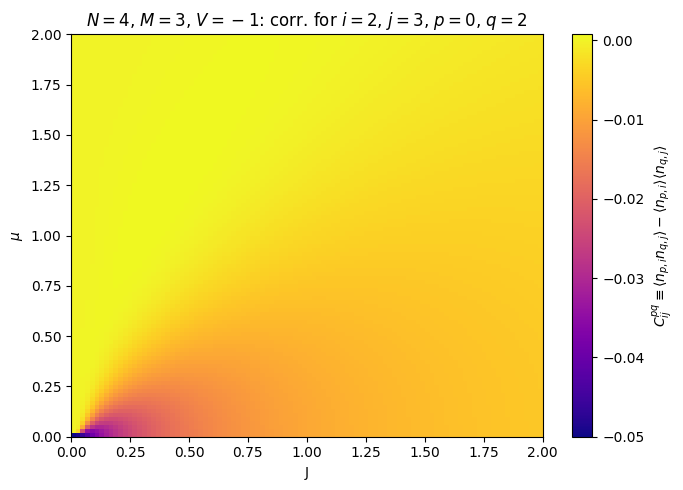

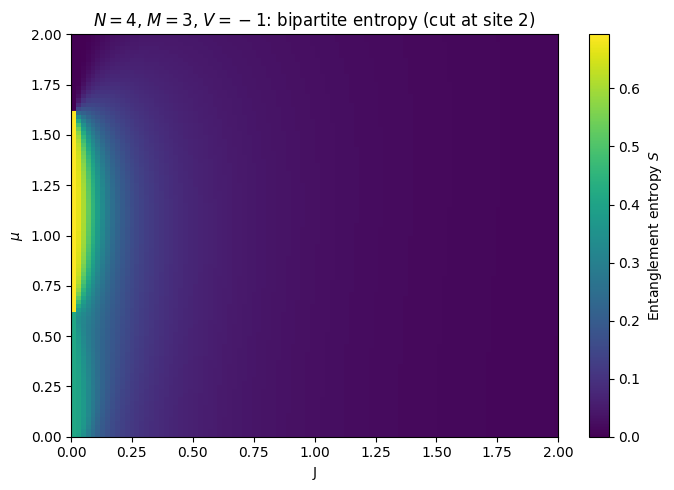

In [6]:
# negative V, no anisotropy at N = 4

N = 4
M = 3
V = -1
anisotropy_factor = 1

states, _ = enumerate_states(N, M)

Js = np.linspace(0, 2, 100)
mus = np.linspace(0, 2, 100)

site_1 = N // 2
site_2 = site_1 + 1

same_synth_level_corr_func_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)
diff_by_1_synth_level_corr_func_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)
diff_by_2_synth_level_corr_func_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)
entropy_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)

for i, mu in enumerate(mus):
    for j, J in enumerate(Js):
        hamiltonian = construct_anisotropic_hamiltonian(N = N, M = M, V = V, mu = mu, J = J, anisotropy_factor=anisotropy_factor) # 0.9 anisotropy factor
        eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)

        P, degenerate_states = construct_ground_state_projector(eigenvalues, eigenvectors)
        d = len(degenerate_states)

        # Entanglement entropy (bipartition in the middle)
        entropies = [compute_entanglement_entropy(N, M, psi, cut_site=N // 2) for psi in degenerate_states]
        entropy_grid[i, j] = np.mean(entropies)
        
        # Correlation function
        op1 = single_site_number_operator(N, M, site_index=site_1, synth_level = 0, states=states)
        for synth_level in range(M):
            op2 = single_site_number_operator(N, M, site_index=site_2, synth_level = synth_level, states=states)
            
            if synth_level == 0:
                O1O2_exp = np.trace(P @ op1 @ op2) / d
                O1_exp = np.trace(P @ op1) / d
                O2_exp = np.trace(P @ op2) / d
                same_synth_level_corr_func_grid[i, j] = np.real(O1O2_exp - O1_exp * O2_exp)
                
            elif synth_level == 1:
                O1O2_exp = np.trace(P @ op1 @ op2) / d
                O1_exp = np.trace(P @ op1) / d
                O2_exp = np.trace(P @ op2) / d
                diff_by_1_synth_level_corr_func_grid[i, j] = np.real(O1O2_exp - O1_exp * O2_exp)
            
            elif synth_level == 2:
                O1O2_exp = np.trace(P @ op1 @ op2) / d
                O1_exp = np.trace(P @ op1) / d
                O2_exp = np.trace(P @ op2) / d
                diff_by_2_synth_level_corr_func_grid[i, j] = np.real(O1O2_exp - O1_exp * O2_exp)
                
fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    same_synth_level_corr_func_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='plasma'
)
fig.colorbar(c, ax=ax, label=r'$C_{ij}^{pq} \equiv \langle n_{p,i} n_{q,j} \rangle - \langle n_{p,i} \rangle \langle n_{q,j} \rangle$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: corr. for $i={site_1}$, $j={site_2}$, $p={0}$, $q={0}$")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    diff_by_1_synth_level_corr_func_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='plasma'
)
fig.colorbar(c, ax=ax, label=r'$C_{ij}^{pq} \equiv \langle n_{p,i} n_{q,j} \rangle - \langle n_{p,i} \rangle \langle n_{q,j} \rangle$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: corr. for $i={site_1}$, $j={site_2}$, $p={0}$, $q={1}$")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    diff_by_2_synth_level_corr_func_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='plasma'
)
fig.colorbar(c, ax=ax, label=r'$C_{ij}^{pq} \equiv \langle n_{p,i} n_{q,j} \rangle - \langle n_{p,i} \rangle \langle n_{q,j} \rangle$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: corr. for $i={site_1}$, $j={site_2}$, $p={0}$, $q={2}$")
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    entropy_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='viridis'
)
fig.colorbar(c, ax=ax, label=r'Entanglement entropy $S$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: bipartite entropy (cut at site {N//2})")
plt.tight_layout()
plt.show()


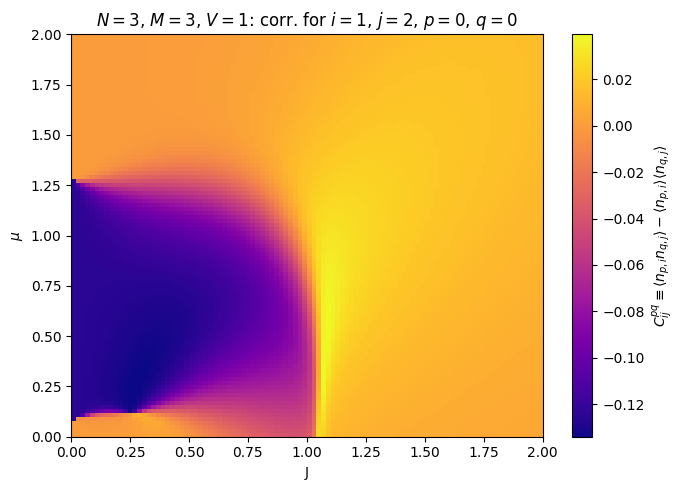

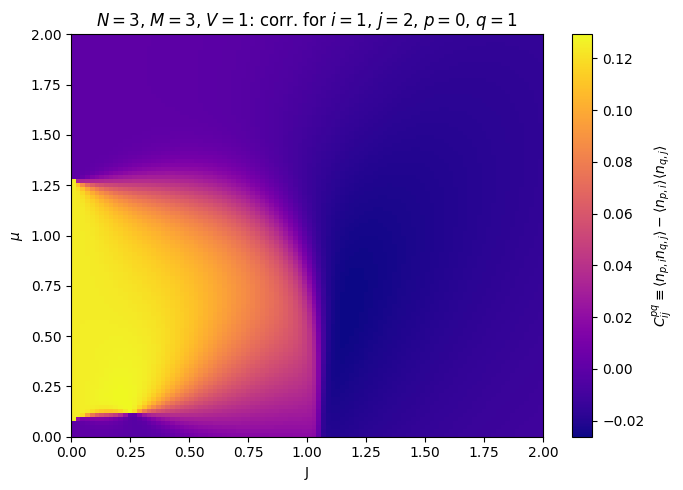

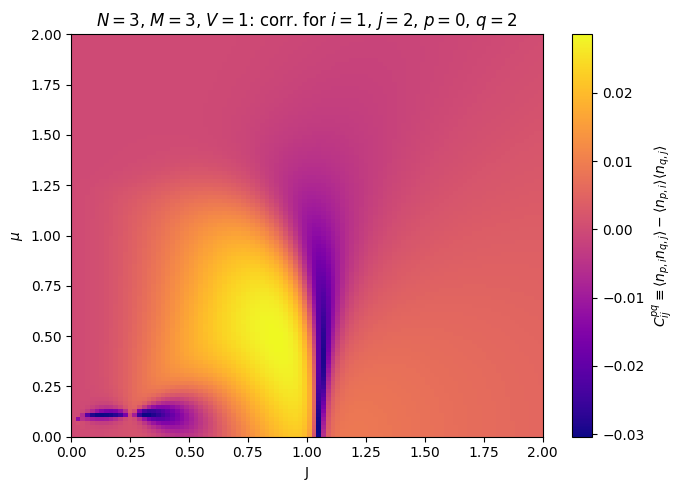

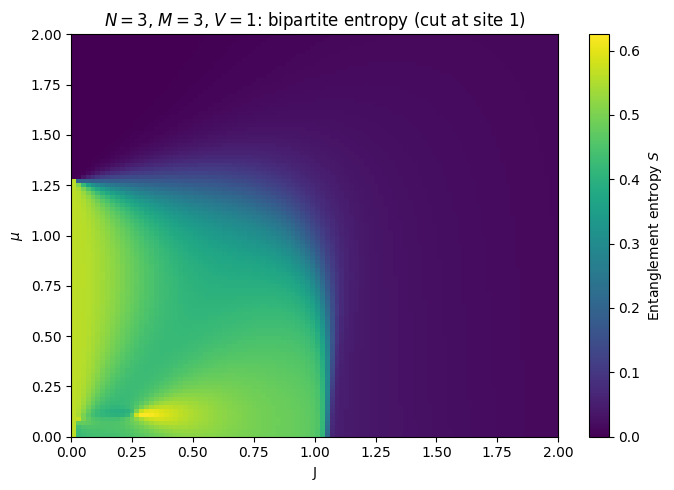

In [8]:
# positive V, 10% anisotropy 

N = 3
M = 3
V = 1
anisotropy_factor = 0.9

states, _ = enumerate_states(N, M)

Js = np.linspace(0, 2, 100)
mus = np.linspace(0, 2, 100)

site_1 = N // 2
site_2 = site_1 + 1

same_synth_level_corr_func_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)
diff_by_1_synth_level_corr_func_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)
diff_by_2_synth_level_corr_func_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)
entropy_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)

for i, mu in enumerate(mus):
    for j, J in enumerate(Js):
        hamiltonian = construct_anisotropic_hamiltonian(N = N, M = M, V = V, mu = mu, J = J, anisotropy_factor=anisotropy_factor) # 0.9 anisotropy factor
        eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)

        P, degenerate_states = construct_ground_state_projector(eigenvalues, eigenvectors)
        d = len(degenerate_states)

        # Entanglement entropy (bipartition in the middle)
        entropies = [compute_entanglement_entropy(N, M, psi, cut_site=N // 2) for psi in degenerate_states]
        entropy_grid[i, j] = np.mean(entropies)
        
        # Correlation function
        op1 = single_site_number_operator(N, M, site_index=site_1, synth_level = 0, states=states)
        for synth_level in range(M):
            op2 = single_site_number_operator(N, M, site_index=site_2, synth_level = synth_level, states=states)
            
            if synth_level == 0:
                O1O2_exp = np.trace(P @ op1 @ op2) / d
                O1_exp = np.trace(P @ op1) / d
                O2_exp = np.trace(P @ op2) / d
                same_synth_level_corr_func_grid[i, j] = np.real(O1O2_exp - O1_exp * O2_exp)
                
            elif synth_level == 1:
                O1O2_exp = np.trace(P @ op1 @ op2) / d
                O1_exp = np.trace(P @ op1) / d
                O2_exp = np.trace(P @ op2) / d
                diff_by_1_synth_level_corr_func_grid[i, j] = np.real(O1O2_exp - O1_exp * O2_exp)
            
            elif synth_level == 2:
                O1O2_exp = np.trace(P @ op1 @ op2) / d
                O1_exp = np.trace(P @ op1) / d
                O2_exp = np.trace(P @ op2) / d
                diff_by_2_synth_level_corr_func_grid[i, j] = np.real(O1O2_exp - O1_exp * O2_exp)
                
fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    same_synth_level_corr_func_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='plasma'
)
fig.colorbar(c, ax=ax, label=r'$C_{ij}^{pq} \equiv \langle n_{p,i} n_{q,j} \rangle - \langle n_{p,i} \rangle \langle n_{q,j} \rangle$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: corr. for $i={site_1}$, $j={site_2}$, $p={0}$, $q={0}$")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    diff_by_1_synth_level_corr_func_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='plasma'
)
fig.colorbar(c, ax=ax, label=r'$C_{ij}^{pq} \equiv \langle n_{p,i} n_{q,j} \rangle - \langle n_{p,i} \rangle \langle n_{q,j} \rangle$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: corr. for $i={site_1}$, $j={site_2}$, $p={0}$, $q={1}$")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    diff_by_2_synth_level_corr_func_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='plasma'
)
fig.colorbar(c, ax=ax, label=r'$C_{ij}^{pq} \equiv \langle n_{p,i} n_{q,j} \rangle - \langle n_{p,i} \rangle \langle n_{q,j} \rangle$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: corr. for $i={site_1}$, $j={site_2}$, $p={0}$, $q={2}$")
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    entropy_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='viridis'
)
fig.colorbar(c, ax=ax, label=r'Entanglement entropy $S$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: bipartite entropy (cut at site {N//2})")
plt.tight_layout()
plt.show()


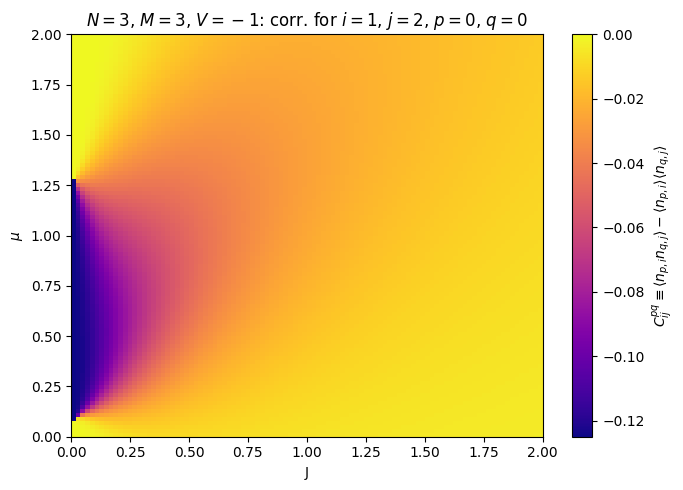

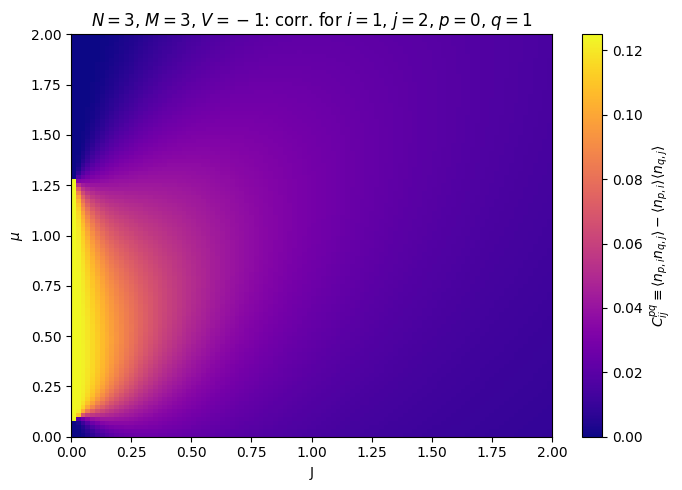

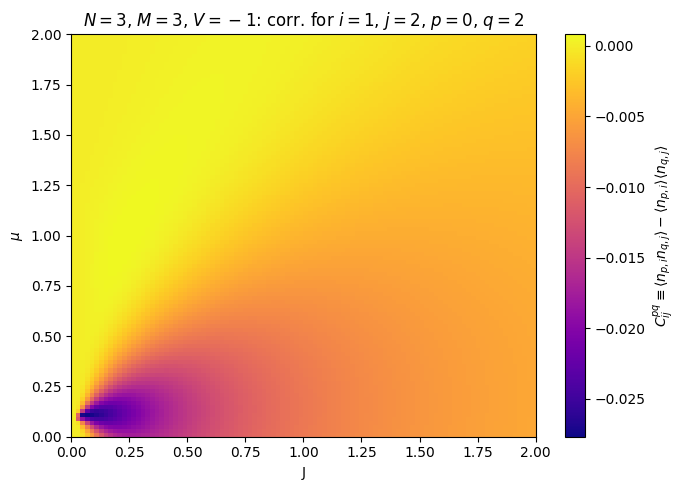

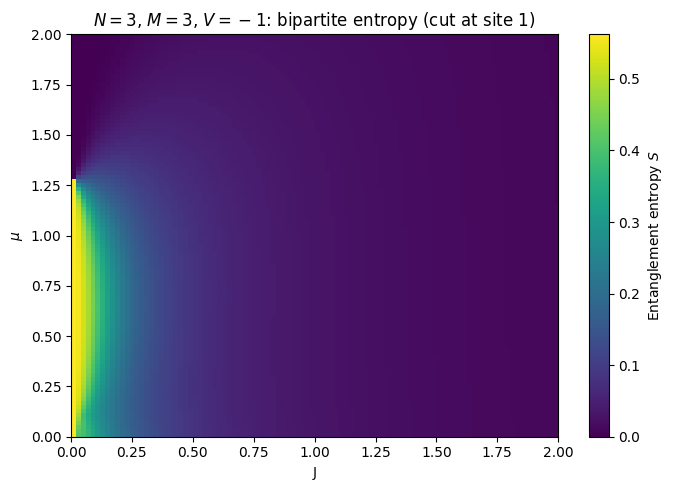

In [9]:
# negative V, 10%  anisotropy 

N = 3
M = 3
V = -1
anisotropy_factor = 0.9

states, _ = enumerate_states(N, M)

Js = np.linspace(0, 2, 100)
mus = np.linspace(0, 2, 100)

site_1 = N // 2
site_2 = site_1 + 1

same_synth_level_corr_func_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)
diff_by_1_synth_level_corr_func_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)
diff_by_2_synth_level_corr_func_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)
entropy_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)

for i, mu in enumerate(mus):
    for j, J in enumerate(Js):
        hamiltonian = construct_anisotropic_hamiltonian(N = N, M = M, V = V, mu = mu, J = J, anisotropy_factor=anisotropy_factor) # 0.9 anisotropy factor
        eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)

        P, degenerate_states = construct_ground_state_projector(eigenvalues, eigenvectors)
        d = len(degenerate_states)

        # Entanglement entropy (bipartition in the middle)
        entropies = [compute_entanglement_entropy(N, M, psi, cut_site=N // 2) for psi in degenerate_states]
        entropy_grid[i, j] = np.mean(entropies)
        
        # Correlation function
        op1 = single_site_number_operator(N, M, site_index=site_1, synth_level = 0, states=states)
        for synth_level in range(M):
            op2 = single_site_number_operator(N, M, site_index=site_2, synth_level = synth_level, states=states)
            
            if synth_level == 0:
                O1O2_exp = np.trace(P @ op1 @ op2) / d
                O1_exp = np.trace(P @ op1) / d
                O2_exp = np.trace(P @ op2) / d
                same_synth_level_corr_func_grid[i, j] = np.real(O1O2_exp - O1_exp * O2_exp)
                
            elif synth_level == 1:
                O1O2_exp = np.trace(P @ op1 @ op2) / d
                O1_exp = np.trace(P @ op1) / d
                O2_exp = np.trace(P @ op2) / d
                diff_by_1_synth_level_corr_func_grid[i, j] = np.real(O1O2_exp - O1_exp * O2_exp)
            
            elif synth_level == 2:
                O1O2_exp = np.trace(P @ op1 @ op2) / d
                O1_exp = np.trace(P @ op1) / d
                O2_exp = np.trace(P @ op2) / d
                diff_by_2_synth_level_corr_func_grid[i, j] = np.real(O1O2_exp - O1_exp * O2_exp)
                
fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    same_synth_level_corr_func_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='plasma'
)
fig.colorbar(c, ax=ax, label=r'$C_{ij}^{pq} \equiv \langle n_{p,i} n_{q,j} \rangle - \langle n_{p,i} \rangle \langle n_{q,j} \rangle$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: corr. for $i={site_1}$, $j={site_2}$, $p={0}$, $q={0}$")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    diff_by_1_synth_level_corr_func_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='plasma'
)
fig.colorbar(c, ax=ax, label=r'$C_{ij}^{pq} \equiv \langle n_{p,i} n_{q,j} \rangle - \langle n_{p,i} \rangle \langle n_{q,j} \rangle$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: corr. for $i={site_1}$, $j={site_2}$, $p={0}$, $q={1}$")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    diff_by_2_synth_level_corr_func_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='plasma'
)
fig.colorbar(c, ax=ax, label=r'$C_{ij}^{pq} \equiv \langle n_{p,i} n_{q,j} \rangle - \langle n_{p,i} \rangle \langle n_{q,j} \rangle$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: corr. for $i={site_1}$, $j={site_2}$, $p={0}$, $q={2}$")
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    entropy_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='viridis'
)
fig.colorbar(c, ax=ax, label=r'Entanglement entropy $S$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: bipartite entropy (cut at site {N//2})")
plt.tight_layout()
plt.show()


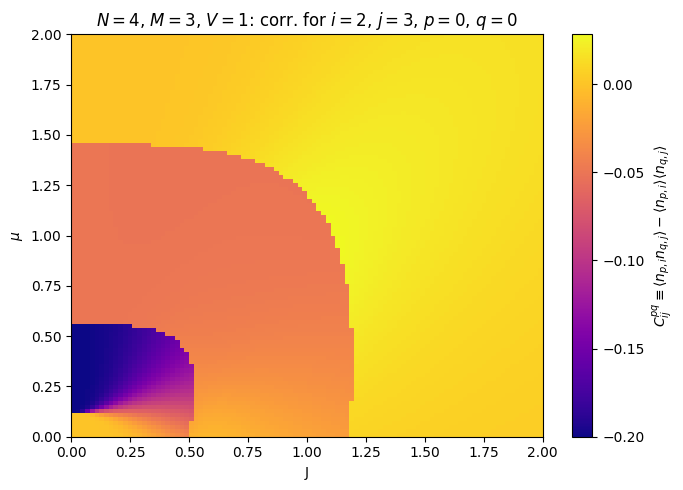

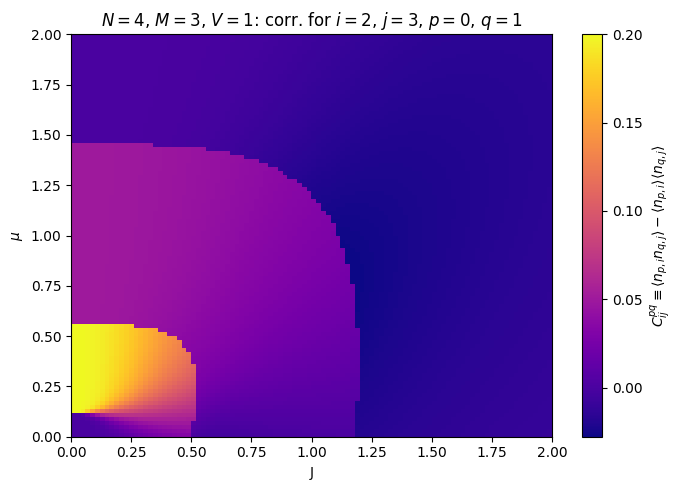

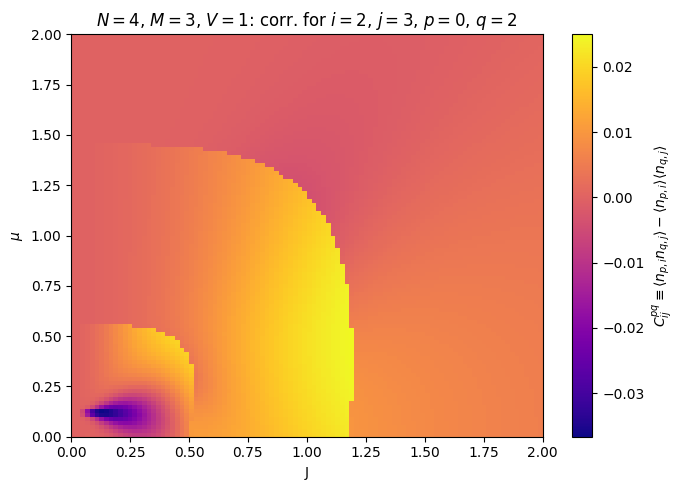

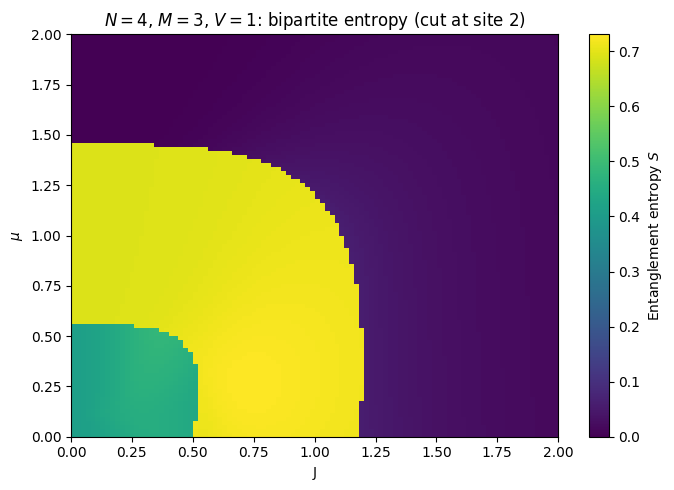

In [3]:
# positive V, 10% anisotropy at N = 4

N = 4
M = 3
V = 1
anisotropy_factor = 0.9

states, _ = enumerate_states(N, M)

Js = np.linspace(0, 2, 100)
mus = np.linspace(0, 2, 100)

site_1 = N // 2
site_2 = site_1 + 1

same_synth_level_corr_func_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)
diff_by_1_synth_level_corr_func_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)
diff_by_2_synth_level_corr_func_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)
entropy_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)

for i, mu in enumerate(mus):
    for j, J in enumerate(Js):
        hamiltonian = construct_anisotropic_hamiltonian(N = N, M = M, V = V, mu = mu, J = J, anisotropy_factor=anisotropy_factor) # 0.9 anisotropy factor
        eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)

        P, degenerate_states = construct_ground_state_projector(eigenvalues, eigenvectors)
        d = len(degenerate_states)

        # Entanglement entropy (bipartition in the middle)
        entropies = [compute_entanglement_entropy(N, M, psi, cut_site=N // 2) for psi in degenerate_states]
        entropy_grid[i, j] = np.mean(entropies)
        
        # Correlation function
        op1 = single_site_number_operator(N, M, site_index=site_1, synth_level = 0, states=states)
        for synth_level in range(M):
            op2 = single_site_number_operator(N, M, site_index=site_2, synth_level = synth_level, states=states)
            
            if synth_level == 0:
                O1O2_exp = np.trace(P @ op1 @ op2) / d
                O1_exp = np.trace(P @ op1) / d
                O2_exp = np.trace(P @ op2) / d
                same_synth_level_corr_func_grid[i, j] = np.real(O1O2_exp - O1_exp * O2_exp)
                
            elif synth_level == 1:
                O1O2_exp = np.trace(P @ op1 @ op2) / d
                O1_exp = np.trace(P @ op1) / d
                O2_exp = np.trace(P @ op2) / d
                diff_by_1_synth_level_corr_func_grid[i, j] = np.real(O1O2_exp - O1_exp * O2_exp)
            
            elif synth_level == 2:
                O1O2_exp = np.trace(P @ op1 @ op2) / d
                O1_exp = np.trace(P @ op1) / d
                O2_exp = np.trace(P @ op2) / d
                diff_by_2_synth_level_corr_func_grid[i, j] = np.real(O1O2_exp - O1_exp * O2_exp)
                
fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    same_synth_level_corr_func_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='plasma'
)
fig.colorbar(c, ax=ax, label=r'$C_{ij}^{pq} \equiv \langle n_{p,i} n_{q,j} \rangle - \langle n_{p,i} \rangle \langle n_{q,j} \rangle$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: corr. for $i={site_1}$, $j={site_2}$, $p={0}$, $q={0}$")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    diff_by_1_synth_level_corr_func_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='plasma'
)
fig.colorbar(c, ax=ax, label=r'$C_{ij}^{pq} \equiv \langle n_{p,i} n_{q,j} \rangle - \langle n_{p,i} \rangle \langle n_{q,j} \rangle$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: corr. for $i={site_1}$, $j={site_2}$, $p={0}$, $q={1}$")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    diff_by_2_synth_level_corr_func_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='plasma'
)
fig.colorbar(c, ax=ax, label=r'$C_{ij}^{pq} \equiv \langle n_{p,i} n_{q,j} \rangle - \langle n_{p,i} \rangle \langle n_{q,j} \rangle$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: corr. for $i={site_1}$, $j={site_2}$, $p={0}$, $q={2}$")
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    entropy_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='viridis'
)
fig.colorbar(c, ax=ax, label=r'Entanglement entropy $S$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: bipartite entropy (cut at site {N//2})")
plt.tight_layout()
plt.show()


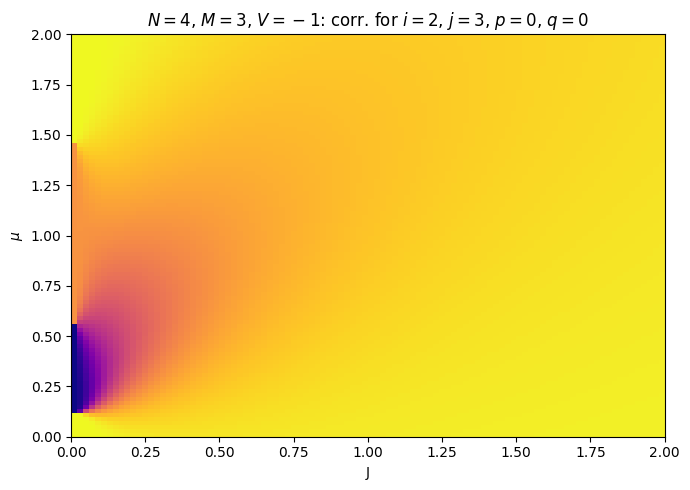

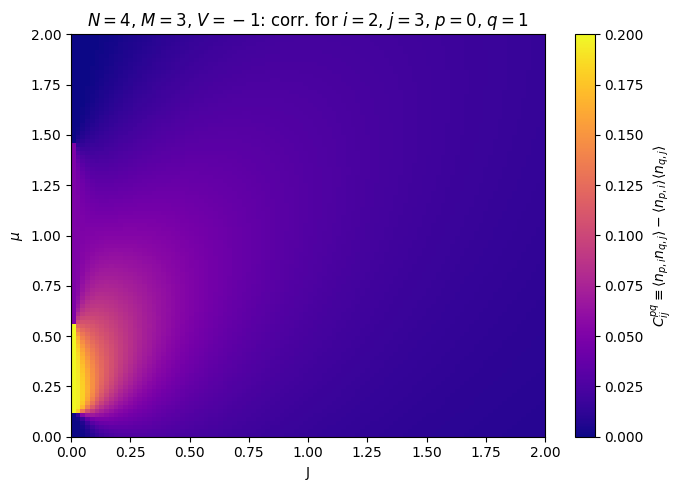

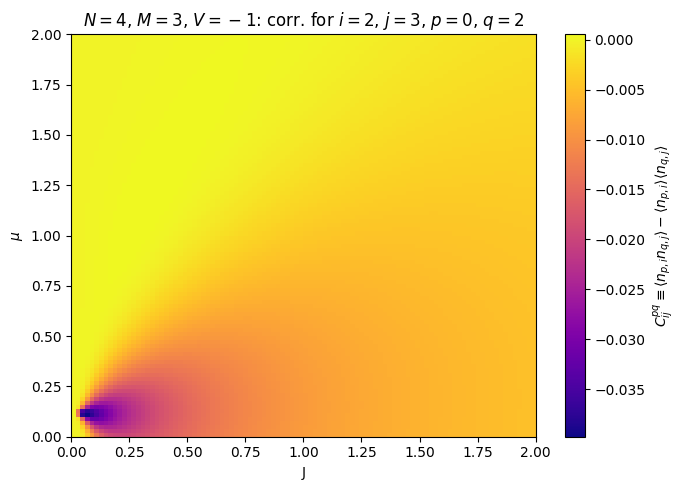

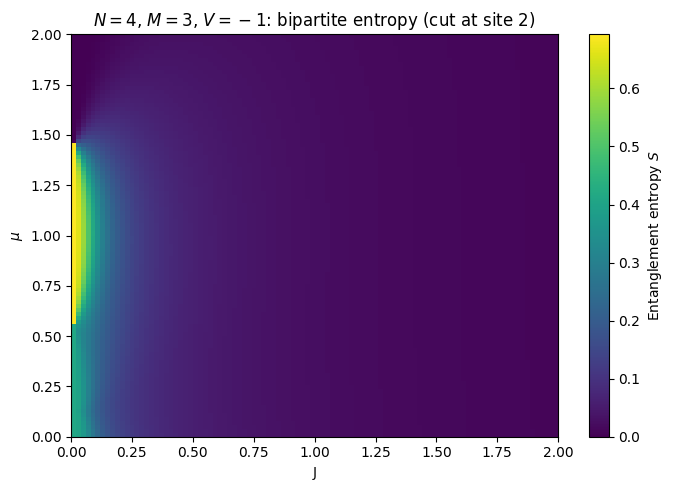

In [11]:
# negative V, 10% anisotropy at N = 4

N = 4
M = 3
V = -1
anisotropy_factor = 0.9

states, _ = enumerate_states(N, M)

Js = np.linspace(0, 2, 100)
mus = np.linspace(0, 2, 100)

site_1 = N // 2
site_2 = site_1 + 1

same_synth_level_corr_func_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)
diff_by_1_synth_level_corr_func_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)
diff_by_2_synth_level_corr_func_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)
entropy_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)

for i, mu in enumerate(mus):
    for j, J in enumerate(Js):
        hamiltonian = construct_anisotropic_hamiltonian(N = N, M = M, V = V, mu = mu, J = J, anisotropy_factor=anisotropy_factor) # 0.9 anisotropy factor
        eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)

        P, degenerate_states = construct_ground_state_projector(eigenvalues, eigenvectors)
        d = len(degenerate_states)

        # Entanglement entropy (bipartition in the middle)
        entropies = [compute_entanglement_entropy(N, M, psi, cut_site=N // 2) for psi in degenerate_states]
        entropy_grid[i, j] = np.mean(entropies)
        
        # Correlation function
        op1 = single_site_number_operator(N, M, site_index=site_1, synth_level = 0, states=states)
        for synth_level in range(M):
            op2 = single_site_number_operator(N, M, site_index=site_2, synth_level = synth_level, states=states)
            
            if synth_level == 0:
                O1O2_exp = np.trace(P @ op1 @ op2) / d
                O1_exp = np.trace(P @ op1) / d
                O2_exp = np.trace(P @ op2) / d
                same_synth_level_corr_func_grid[i, j] = np.real(O1O2_exp - O1_exp * O2_exp)
                
            elif synth_level == 1:
                O1O2_exp = np.trace(P @ op1 @ op2) / d
                O1_exp = np.trace(P @ op1) / d
                O2_exp = np.trace(P @ op2) / d
                diff_by_1_synth_level_corr_func_grid[i, j] = np.real(O1O2_exp - O1_exp * O2_exp)
            
            elif synth_level == 2:
                O1O2_exp = np.trace(P @ op1 @ op2) / d
                O1_exp = np.trace(P @ op1) / d
                O2_exp = np.trace(P @ op2) / d
                diff_by_2_synth_level_corr_func_grid[i, j] = np.real(O1O2_exp - O1_exp * O2_exp)
                
fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    same_synth_level_corr_func_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='plasma'
)
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: corr. for $i={site_1}$, $j={site_2}$, $p={0}$, $q={0}$")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    diff_by_1_synth_level_corr_func_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='plasma'
)
fig.colorbar(c, ax=ax, label=r'$C_{ij}^{pq} \equiv \langle n_{p,i} n_{q,j} \rangle - \langle n_{p,i} \rangle \langle n_{q,j} \rangle$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: corr. for $i={site_1}$, $j={site_2}$, $p={0}$, $q={1}$")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    diff_by_2_synth_level_corr_func_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='plasma'
)
fig.colorbar(c, ax=ax, label=r'$C_{ij}^{pq} \equiv \langle n_{p,i} n_{q,j} \rangle - \langle n_{p,i} \rangle \langle n_{q,j} \rangle$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: corr. for $i={site_1}$, $j={site_2}$, $p={0}$, $q={2}$")
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    entropy_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='viridis'
)
fig.colorbar(c, ax=ax, label=r'Entanglement entropy $S$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N={N}$, $M={M}$, $V={V}$: bipartite entropy (cut at site {N//2})")
plt.tight_layout()
plt.show()
